In [ ]:
# Bu hücre sadece gerekli kütüphaneleri kurar.
!pip install -q diffusers transformers accelerate torch torchvision Pillow
print("Kütüphaneler kuruldu veya zaten kurulu.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
Kütüphaneler kuruldu veya zaten kurulu.


In [ ]:
# Bu hücre kütüphaneleri import eder, Drive'ı bağlar, yolları ayarlar
# ve temel konfigürasyonları yapar.

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from PIL import Image
import os
import json
import math
import time
from google.colab import drive
from IPython.display import display, Image as IPImage
from PIL import Image, ImageOps
# --- Google Drive Bağlantısı ---
try:
    drive.mount('/content/drive')
    drive_mounted = True
    print("Google Drive başarıyla bağlandı.")
except Exception as e:
    print(f"!! Google Drive bağlanamadı: {e}")
    drive_mounted = False

# --- Temel Ayarlar ---
if drive_mounted:
    # LÜTFEN BU YOLU KENDİ GOOGLE DRIVE KLASÖR YAPINIZA GÖRE GÜNCELLEYİN!
    base_project_dir = '/content/drive/MyDrive/Research_Project_ImageEditing/' # Örnek yol
    print(f"Proje kök dizini: {base_project_dir}")

    metadata_file = os.path.join(base_project_dir, "metadata.json") # Meta-veri dosyasının tam yolu
    image_base_dir = base_project_dir # Resim ve Maske klasörlerinin üst dizini
    output_base_dir = os.path.join(base_project_dir, "Outputs")

    # --- Çıktı Klasörü Ayarları ---
    model_output_folder = "InstructPix2Pix"
    output_dir = os.path.join(output_base_dir, model_output_folder)
    os.makedirs(output_dir, exist_ok=True)
    print(f"Çıktı klasörü: {output_dir}")

    # --- Cihaz Ayarı ---
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Kullanılan cihaz: {device}")

    # --- Yeniden Boyutlandırma Ayarı (InstructPix2Pix SADECE LowRes kullanacak) ---
    # En uzun kenar bu piksel değerine indirilecek
    low_res_longest_side = 512
    print(f"Hedef Düşük Çözünürlük (En Uzun Kenar): {low_res_longest_side}px")

    # --- Model Parametreleri (Ayarlanabilir) ---
    inference_steps = 10
    image_guidance = 1.5
    text_guidance = 7.5
    print(f"Model Parametreleri: steps={inference_steps}, img_guidance={image_guidance}, text_guidance={text_guidance}")

    setup_complete = True
else:
    print("!! Drive bağlanamadığı için kuruluma devam edilemiyor.")
    setup_complete = False

# --- Yardımcı Fonksiyon: Görüntüyü Yeniden Boyutlandırma ---


def resize_image_multiple_of_64(image, longest_side):
    """
    Bir görüntüyü, en uzun kenarı belirtilen 'longest_side' değerine eşit veya daha küçük olacak
    şekilde yeniden boyutlandırır, en boy oranını korur ve SONUÇ boyutlarının (genişlik ve yükseklik)
    64'ün katları olmasını sağlar.

    Args:
        image (PIL.Image.Image): Yeniden boyutlandırılacak PIL Görüntü nesnesi.
        longest_side (int): En uzun kenarın hedef maksimum piksel değeri.

    Returns:
        PIL.Image.Image: Yeniden boyutlandırılmış PIL Görüntü nesnesi.
    """
    width, height = image.size
    original_size_str = f"{width}x{height}" # Orijinal boyutu loglamak için sakla

    # 1. Adım: Hedef boyuta göre ilk ölçeklemeyi hesapla (en boy oranını koruyarak)
    if max(width, height) <= longest_side:
        # Eğer zaten yeterince küçükse, hedef boyutlar mevcut boyutlardır
        target_w, target_h = width, height
        print(f" - Görüntü zaten hedef 'longest_side' ({longest_side}) değerinden küçük veya eşit ({original_size_str}). 64'ün katlarına ayarlanacak.")
    else:
        # Eğer daha büyükse, 'longest_side'a göre küçült
        if width > height:
            ratio = longest_side / width
            target_w = longest_side
            target_h = int(height * ratio)
        else:
            ratio = longest_side / height
            target_h = longest_side
            target_w = int(width * ratio)
        print(f" - Görüntü {original_size_str} boyutundan 'longest_side'={longest_side} hedefine göre ~{target_w}x{target_h} boyutuna ölçekleniyor.")

    # 2. Adım: Hesaplanan hedef boyutları 64'ün en yakın katına yuvarla
    final_w = round(target_w / 64) * 64
    final_h = round(target_h / 64) * 64

    # 3. Adım: Çok küçük boyutları önlemek için minimum boyut kontrolü
    if final_w == 0:
        final_w = 64
        print(f" - Uyarı: Hesaplanan genişlik 0 idi, minimum 64 olarak ayarlandı.")
    if final_h == 0:
        final_h = 64
        print(f" - Uyarı: Hesaplanan yükseklik 0 idi, minimum 64 olarak ayarlandı.")

    final_size_str = f"{final_w}x{final_h}"

    # 4. Adım: Eğer son boyutlar orijinal boyutlarla aynıysa, gereksiz yere yeniden boyutlandırma yapma
    if final_w == width and final_h == height:
        print(f" - Son hedef boyut ({final_size_str}), orijinal boyutla aynı. Yeniden boyutlandırma atlanıyor.")
        return image

    # 5. Adım: Görüntüyü son, 64'ün katı olan boyutlara yeniden boyutlandır
    try:
        print(f" - Görüntü son olarak {final_size_str} (64'ün katı) boyutuna yeniden boyutlandırılıyor...")
        # Yüksek kaliteli küçültme/büyütme için LANCZOS filtresi
        resized_image = image.resize((final_w, final_h), Image.Resampling.LANCZOS)
        print(f" - Yeniden boyutlandırma tamamlandı.")
        return resized_image
    except Exception as e:
        print(f"!! Görüntü yeniden boyutlandırma sırasında hata: {e}")
        # Hata durumunda orijinal görüntüyü döndürmek bir seçenek olabilir,
        # ancak bu sonraki adımlarda sorun yaratabilir. None döndürmek veya hatayı yükseltmek daha iyi olabilir.
        # Şimdilik hatayı loglayıp orijinali döndürelim, ama bu durumu göz önünde bulundur.
        # return image
        raise  # Hatayı yukarıya bildir, böylece işlem durur

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive başarıyla bağlandı.
Proje kök dizini: /content/drive/MyDrive/SNU_Project_ImageEditing/
Çıktı klasörü: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix
Kullanılan cihaz: cuda
Hedef Düşük Çözünürlük (En Uzun Kenar): 512px
Model Parametreleri: steps=10, img_guidance=1.5, text_guidance=7.5


In [ ]:
# Bu hücre SADECE InstructPix2Pix modelini yükler.
# Döngü içinde tekrar yüklenmeyecek.

model_loaded = False
if setup_complete:
    print("\nInstructPix2Pix modeli yükleniyor...")
    start_time = time.time()
    try:
        pipe_ip2p = StableDiffusionInstructPix2PixPipeline.from_pretrained(
            "timbrooks/instruct-pix2pix",
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            safety_checker=None
        ).to(device)
        pipe_ip2p.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_ip2p.scheduler.config)
        end_time = time.time()
        print(f"- InstructPix2Pix modeli başarıyla yüklendi ({end_time - start_time:.2f} saniye).")
        model_loaded = True
    except Exception as e:
        print(f"!! InstructPix2Pix yüklenirken HATA: {e}")
        print("!! Bellek hatası alıyorsanız, Colab Runtime'ı (GPU) yeniden başlatmayı deneyin.")
        pipe_ip2p = None
else:
    print("!! Kurulum tamamlanmadığı için model yüklenemiyor.")


InstructPix2Pix modeli yükleniyor...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

- InstructPix2Pix modeli başarıyla yüklendi (18.22 saniye).


In [ ]:
# Bu hücre metadata.json dosyasını okur ve tüm girdileri işler.

if model_loaded and setup_complete:
    print("\n--- Toplu İşlem Başlatılıyor ---")

    # Metadata dosyasını yükle
    try:
        with open(metadata_file, 'r', encoding='utf-8') as f:
            metadata = json.load(f)
        print(f"- Metadata dosyası başarıyla okundu ({len(metadata)} girdi bulundu).")
    except Exception as e:
        print(f"!! Metadata dosyası okunamadı: {e}")
        metadata = [] # Hata durumunda boş liste ile devam etmeyi engelle

    failed_entries = [] # Hata alan girdileri takip etmek için liste
    processed_count = 0

    total_entries = len(metadata)
    loop_start_time = time.time()

    for i, entry in enumerate(metadata):
        entry_id = entry.get("entry_id", f"unknown_entry_{i+1}")
        print(f"\n[{i+1}/{total_entries}] İşleniyor: {entry_id}")
        entry_start_time = time.time()

        try:
            # Gerekli bilgileri JSON'dan al
            input_rel_path = entry.get("input_image_path")
            instruction = entry.get("instruction_ip2p")

            if not input_rel_path or not instruction:
                raise ValueError("JSON girdisinde 'input_image_path' veya 'instruction_ip2p' eksik.")

            input_abs_path = os.path.join(image_base_dir, input_rel_path)

            # Çıktı dosya adını ve yolunu oluştur
            # Sadece LowRes üretilecek
            output_filename = f"{entry_id}_LowRes_output.png"
            output_abs_path = os.path.join(output_dir, output_filename)

            # Eğer çıktı zaten varsa atla (isteğe bağlı, zaman kazandırır)
            # if os.path.exists(output_abs_path):
            #     print(f" - Çıktı dosyası zaten var, atlanıyor: {output_filename}")
            #     processed_count += 1
            #     continue # Bu girdiyi atla ve sonraki girdiye geç

            # Girdi resmini yükle
            if not os.path.exists(input_abs_path):
                raise FileNotFoundError(f"Girdi resmi bulunamadı: {input_abs_path}")

            init_image = load_image(input_abs_path).convert("RGB")
            print(f" - Girdi resmi yüklendi: {input_abs_path} (Boyut: {init_image.size})")

            # Görüntüyü Low Resolution'a indir
            resized_image = resize_image_multiple_of_64(init_image, low_res_longest_side)

            # Modeli çalıştır
            print(f" - Model çalıştırılıyor (Talimat: '{instruction[:50]}...')")
            model_run_start_time = time.time()
            edited_image = pipe_ip2p(
                prompt=instruction,
                image=resized_image,
                num_inference_steps=inference_steps,
                image_guidance_scale=image_guidance,
                guidance_scale=text_guidance
            ).images[0]
            model_run_end_time = time.time()
            print(f" - Model çalışması tamamlandı ({model_run_end_time - model_run_start_time:.2f} saniye).")

            # Çıktıyı kaydet
            edited_image.save(output_abs_path)
            print(f" - Çıktı kaydedildi: {output_abs_path}")
            processed_count += 1

            # (İsteğe bağlı) Her adımdan sonra Colab'da gösterme - çok fazla olursa yavaşlatabilir
            # display(IPImage(output_abs_path, width=300))

        except Exception as e:
            error_message = f"HATA ({entry_id}): {e}"
            print(f"!! {error_message}")
            failed_entries.append({"entry_id": entry_id, "error": str(e)})

        entry_end_time = time.time()
        print(f" - Girdi {entry_id} tamamlandı ({entry_end_time - entry_start_time:.2f} saniye).")

    loop_end_time = time.time()
    print(f"\n--- Toplu İşlem Tamamlandı ---")
    print(f"Toplam Süre: {(loop_end_time - loop_start_time)/60:.2f} dakika")
    print(f"Başarıyla İşlenen Girdi Sayısı: {processed_count}/{total_entries}")

    # Hataları Raporla
    if failed_entries:
        print("\n--- Hata Alan Girdiler ---")
        for fail in failed_entries:
            print(f"- ID: {fail['entry_id']}, Hata: {fail['error']}")
    else:
        print("\n- Tüm girdiler hatasız işlendi.")

else:
    print("!! Model yüklenemediği veya kurulum tamamlanmadığı için toplu işlem başlatılamıyor.")


--- Toplu İşlem Başlatılıyor ---
- Metadata dosyası başarıyla okundu (96 girdi bulundu).

[1/96] İşleniyor: Portrait_01_WomanHatAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_01_WomanHatAdd.png (Boyut: (3744, 5616))
 - Görüntü 3744x5616 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Put a summer hat on her head...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (3.62 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_01_WomanHatAdd_LowRes_output.png
 - Girdi Portrait_01_WomanHatAdd tamamlandı (4.68 saniye).

[2/96] İşleniyor: Portrait_02_ManNecklaceAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_02_ManNecklaceAdd.png (Boyut: (3149, 4724))
 - Görüntü 3149x4724 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a silver chain necklace around his neck...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.58 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_02_ManNecklaceAdd_LowRes_output.png
 - Girdi Portrait_02_ManNecklaceAdd tamamlandı (2.05 saniye).

[3/96] İşleniyor: Portrait_03_WomanGlassesRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_03_WomanGlassesRemove.png (Boyut: (8000, 12000))
 - Görüntü 8000x12000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove her glasses...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_03_WomanGlassesRemove_LowRes_output.png
 - Girdi Portrait_03_WomanGlassesRemove tamamlandı (4.32 saniye).

[4/96] İşleniyor: Portrait_04_NoseRingRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_04_NoseRingRemove.png (Boyut: (2400, 3600))
 - Görüntü 2400x3600 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the nose ring...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.62 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_04_NoseRingRemove_LowRes_output.png
 - Girdi Portrait_04_NoseRingRemove tamamlandı (2.00 saniye).

[5/96] İşleniyor: Portrait_05_ManShirtReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_05_ManShirtReplace.png (Boyut: (4328, 2885))
 - Görüntü 4328x2885 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change his t-shirt to a patterned Hawaiian shirt...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_05_ManShirtReplace_LowRes_output.png
 - Girdi Portrait_05_ManShirtReplace tamamlandı (2.35 saniye).

[6/96] İşleniyor: Portrait_06_WomanEarringReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_06_WomanEarringReplace.png (Boyut: (4000, 6000))
 - Görüntü 4000x6000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change her earrings to long, dangling gold earring...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.74 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_06_WomanEarringReplace_LowRes_output.png
 - Girdi Portrait_06_WomanEarringReplace tamamlandı (2.52 saniye).

[7/96] İşleniyor: Portrait_07_WomanLipstickChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_07_WomanLipstickChange.png (Boyut: (4752, 3168))
 - Görüntü 4752x3168 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make her lipstick dark purple...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_07_WomanLipstickChange_LowRes_output.png
 - Girdi Portrait_07_WomanLipstickChange tamamlandı (2.21 saniye).

[8/96] İşleniyor: Portrait_08_ManEyeColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_08_ManEyeColorChange.png (Boyut: (5257, 3935))
 - Görüntü 5257x3935 boyutundan 'longest_side'=512 hedefine göre ~512x383 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change his eyes to bright blue...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.05 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_08_ManEyeColorChange_LowRes_output.png
 - Girdi Portrait_08_ManEyeColorChange tamamlandı (2.74 saniye).

[9/96] İşleniyor: Portrait_09_HeadbandMaterialChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_09_HeadbandMaterialChange.png (Boyut: (6016, 4016))
 - Görüntü 6016x4016 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make her headband shiny metallic gold...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.68 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_09_HeadbandMaterialChange_LowRes_output.png
 - Girdi Portrait_09_HeadbandMaterialChange tamamlandı (2.42 saniye).

[10/96] İşleniyor: Portrait_10_ManBeardToStone
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_10_ManBeardToStone.png (Boyut: (3300, 4800))
 - Görüntü 3300x4800 boyutundan 'longest_side'=512 hedefine göre ~352x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make his beard look like stone...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.07 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_10_ManBeardToStone_LowRes_output.png
 - Girdi Portrait_10_ManBeardToStone tamamlandı (2.76 saniye).

[11/96] İşleniyor: Portrait_11_ToComicStyle
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_11_ToComicStyle.png (Boyut: (4912, 7360))
 - Görüntü 4912x7360 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this look like a comic book drawing...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.63 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_11_ToComicStyle_LowRes_output.png
 - Girdi Portrait_11_ToComicStyle tamamlandı (3.22 saniye).

[12/96] İşleniyor: Portrait_12_ToOilPainting
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_12_ToOilPainting.png (Boyut: (3000, 4499))
 - Görüntü 3000x4499 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Turn this into an oil painting...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_12_ToOilPainting_LowRes_output.png
 - Girdi Portrait_12_ToOilPainting tamamlandı (2.22 saniye).

[13/96] İşleniyor: Portrait_13_ToNightLighting
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_13_ToNightLighting.png (Boyut: (3285, 5000))
 - Görüntü 3285x5000 boyutundan 'longest_side'=512 hedefine göre ~336x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make it look like nighttime with moonlight...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.64 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_13_ToNightLighting_LowRes_output.png
 - Girdi Portrait_13_ToNightLighting tamamlandı (2.25 saniye).

[14/96] İşleniyor: Portrait_14_ToGoldenHour
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_14_ToGoldenHour.png (Boyut: (2219, 3329))
 - Görüntü 2219x3329 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add warm golden hour lighting...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_14_ToGoldenHour_LowRes_output.png
 - Girdi Portrait_14_ToGoldenHour tamamlandı (1.94 saniye).

[15/96] İşleniyor: Portrait_15_MakeSmile
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_15_MakeSmile.png (Boyut: (2800, 4000))
 - Görüntü 2800x4000 boyutundan 'longest_side'=512 hedefine göre ~358x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the person smile...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.07 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_15_MakeSmile_LowRes_output.png
 - Girdi Portrait_15_MakeSmile tamamlandı (2.45 saniye).

[16/96] İşleniyor: Portrait_16_AddAging
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Portrait_16_AddAging.png (Boyut: (4000, 6000))
 - Görüntü 4000x6000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the person look older, add wrinkles and gray ...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.68 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Portrait_16_AddAging_LowRes_output.png
 - Girdi Portrait_16_AddAging tamamlandı (2.82 saniye).

[17/96] İşleniyor: Landscape_01_LakeBoatAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_01_LakeBoatAdd.png (Boyut: (3024, 3024))
 - Görüntü 3024x3024 boyutundan 'longest_side'=512 hedefine göre ~512x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a small wooden boat on the lake...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.68 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_01_LakeBoatAdd_LowRes_output.png
 - Girdi Landscape_01_LakeBoatAdd tamamlandı (3.07 saniye).

[18/96] İşleniyor: Landscape_02_ForestCabinAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_02_ForestCabinAdd.png (Boyut: (4016, 6016))
 - Görüntü 4016x6016 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a log cabin in the forest...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.63 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_02_ForestCabinAdd_LowRes_output.png
 - Girdi Landscape_02_ForestCabinAdd tamamlandı (2.46 saniye).

[19/96] İşleniyor: Landscape_03_LoneTreeRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_03_LoneTreeRemove.png (Boyut: (3707, 3367))
 - Görüntü 3707x3367 boyutundan 'longest_side'=512 hedefine göre ~512x465 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x448 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the tree...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.38 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_03_LoneTreeRemove_LowRes_output.png
 - Girdi Landscape_03_LoneTreeRemove tamamlandı (2.86 saniye).

[20/96] İşleniyor: Landscape_04_HikerRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_04_HikerRemove.png (Boyut: (5472, 3648))
 - Görüntü 5472x3648 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the person...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_04_HikerRemove_LowRes_output.png
 - Girdi Landscape_04_HikerRemove tamamlandı (2.52 saniye).

[21/96] İşleniyor: Landscape_05_RockToBushReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_05_RockToBushReplace.png (Boyut: (4032, 3024))
 - Görüntü 4032x3024 boyutundan 'longest_side'=512 hedefine göre ~512x384 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the rock with a flowering bush...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.04 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_05_RockToBushReplace_LowRes_output.png
 - Girdi Landscape_05_RockToBushReplace tamamlandı (2.73 saniye).

[22/96] İşleniyor: Landscape_06_GrassToFlowersReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_06_GrassToFlowersReplace.png (Boyut: (4000, 6000))
 - Görüntü 4000x6000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the grass patch with wildflowers...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_06_GrassToFlowersReplace_LowRes_output.png
 - Girdi Landscape_06_GrassToFlowersReplace tamamlandı (2.39 saniye).

[23/96] İşleniyor: Landscape_07_SkyColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_07_SkyColorChange.png (Boyut: (4032, 3024))
 - Görüntü 4032x3024 boyutundan 'longest_side'=512 hedefine göre ~512x384 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the sky look like a sunset with purple and or...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.03 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_07_SkyColorChange_LowRes_output.png
 - Girdi Landscape_07_SkyColorChange tamamlandı (2.47 saniye).

[24/96] İşleniyor: Landscape_08_WaterColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_08_WaterColorChange.png (Boyut: (4000, 6000))
 - Görüntü 4000x6000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the water turquoise green...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.60 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_08_WaterColorChange_LowRes_output.png
 - Girdi Landscape_08_WaterColorChange tamamlandı (2.37 saniye).

[25/96] İşleniyor: Landscape_09_RocksToIce
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_09_RocksToIce.png (Boyut: (3444, 3238))
 - Görüntü 3444x3238 boyutundan 'longest_side'=512 hedefine göre ~512x481 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the rocks look like they are made of ice...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_09_RocksToIce_LowRes_output.png
 - Girdi Landscape_09_RocksToIce tamamlandı (3.16 saniye).

[26/96] İşleniyor: Landscape_10_TreeBarkToMetal
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_10_TreeBarkToMetal.png (Boyut: (7952, 5304))
 - Görüntü 7952x5304 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the tree trunk look like shiny metal...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_10_TreeBarkToMetal_LowRes_output.png
 - Girdi Landscape_10_TreeBarkToMetal tamamlandı (3.75 saniye).

[27/96] İşleniyor: Landscape_11_ToWatercolor
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_11_ToWatercolor.png (Boyut: (3648, 2736))
 - Görüntü 3648x2736 boyutundan 'longest_side'=512 hedefine göre ~512x384 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Turn this photo into a watercolor painting...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.01 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_11_ToWatercolor_LowRes_output.png
 - Girdi Landscape_11_ToWatercolor tamamlandı (2.42 saniye).

[28/96] İşleniyor: Landscape_12_ToImpressionist
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_12_ToImpressionist.png (Boyut: (4624, 2604))
 - Görüntü 4624x2604 boyutundan 'longest_side'=512 hedefine göre ~512x288 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x256 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this look like an Impressionist painting...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.35 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_12_ToImpressionist_LowRes_output.png
 - Girdi Landscape_12_ToImpressionist tamamlandı (1.79 saniye).

[29/96] İşleniyor: Landscape_13_ToFoggy
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_13_ToFoggy.png (Boyut: (5184, 3888))
 - Görüntü 5184x3888 boyutundan 'longest_side'=512 hedefine göre ~512x384 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add dense fog to the landscape...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.09 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_13_ToFoggy_LowRes_output.png
 - Girdi Landscape_13_ToFoggy tamamlandı (3.25 saniye).

[30/96] İşleniyor: Landscape_14_ToRainy
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_14_ToRainy.png (Boyut: (3888, 5184))
 - Görüntü 3888x5184 boyutundan 'longest_side'=512 hedefine göre ~384x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make it look like it's raining heavily...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.98 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_14_ToRainy_LowRes_output.png
 - Girdi Landscape_14_ToRainy tamamlandı (2.70 saniye).

[31/96] İşleniyor: Landscape_15_ToAutumn
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_15_ToAutumn.png (Boyut: (3872, 2592))
 - Görüntü 3872x2592 boyutundan 'longest_side'=512 hedefine göre ~512x342 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the season to autumn, make the leaves red a...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_15_ToAutumn_LowRes_output.png
 - Girdi Landscape_15_ToAutumn tamamlandı (2.37 saniye).

[32/96] İşleniyor: Landscape_16_AddSnow
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Landscape_16_AddSnow.png (Boyut: (5184, 3456))
 - Görüntü 5184x3456 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add snow cover to the mountains...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.63 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Landscape_16_AddSnow_LowRes_output.png
 - Girdi Landscape_16_AddSnow tamamlandı (2.22 saniye).

[33/96] İşleniyor: Urban_01_AddClassicCar
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_01_AddClassicCar.png (Boyut: (3024, 4032))
 - Görüntü 3024x4032 boyutundan 'longest_side'=512 hedefine göre ~384x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a classic red convertible car parked here...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.99 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_01_AddClassicCar_LowRes_output.png
 - Girdi Urban_01_AddClassicCar tamamlandı (2.41 saniye).

[34/96] İşleniyor: Urban_02_AddGraffiti
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_02_AddGraffiti.png (Boyut: (5999, 3984))
 - Görüntü 5999x3984 boyutundan 'longest_side'=512 hedefine göre ~512x340 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add colorful graffiti on the wall...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.64 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_02_AddGraffiti_LowRes_output.png
 - Girdi Urban_02_AddGraffiti tamamlandı (2.42 saniye).

[35/96] İşleniyor: Urban_03_RemoveTrashCan
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_03_RemoveTrashCan.png (Boyut: (6000, 4000))
 - Görüntü 6000x4000 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the trash can...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.64 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_03_RemoveTrashCan_LowRes_output.png
 - Girdi Urban_03_RemoveTrashCan tamamlandı (2.37 saniye).

[36/96] İşleniyor: Urban_04_RemoveSignage
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_04_RemoveSignage.png (Boyut: (6000, 4000))
 - Görüntü 6000x4000 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the billboard...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_04_RemoveSignage_LowRes_output.png
 - Girdi Urban_04_RemoveSignage tamamlandı (2.34 saniye).

[37/96] İşleniyor: Urban_05_BenchReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_05_BenchReplace.png (Boyut: (4032, 3024))
 - Görüntü 4032x3024 boyutundan 'longest_side'=512 hedefine göre ~512x384 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the bench with an ornate wooden bench...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.04 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_05_BenchReplace_LowRes_output.png
 - Girdi Urban_05_BenchReplace tamamlandı (2.67 saniye).

[38/96] İşleniyor: Urban_06_LampPostReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_06_LampPostReplace.png (Boyut: (2592, 4607))
 - Görüntü 2592x4607 boyutundan 'longest_side'=512 hedefine göre ~288x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 256x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the street lamp to a vintage gas lamp style...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.33 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_06_LampPostReplace_LowRes_output.png
 - Girdi Urban_06_LampPostReplace tamamlandı (1.71 saniye).

[39/96] İşleniyor: Urban_07_BuildingColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_07_BuildingColorChange.png (Boyut: (5974, 3983))
 - Görüntü 5974x3983 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the building bright blue...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_07_BuildingColorChange_LowRes_output.png
 - Girdi Urban_07_BuildingColorChange tamamlandı (2.40 saniye).

[40/96] İşleniyor: Urban_08_TaxiColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_08_TaxiColorChange.png (Boyut: (5975, 3361))
 - Görüntü 5975x3361 boyutundan 'longest_side'=512 hedefine göre ~512x288 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x256 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the taxi green...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.38 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_08_TaxiColorChange_LowRes_output.png
 - Girdi Urban_08_TaxiColorChange tamamlandı (1.92 saniye).

[41/96] İşleniyor: Urban_09_RoadToCobblestone
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_09_RoadToCobblestone.png (Boyut: (5472, 3648))
 - Görüntü 5472x3648 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the road to cobblestone...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_09_RoadToCobblestone_LowRes_output.png
 - Girdi Urban_09_RoadToCobblestone tamamlandı (2.34 saniye).

[42/96] İşleniyor: Urban_10_WallToGlass
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_10_WallToGlass.png (Boyut: (4272, 2848))
 - Görüntü 4272x2848 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this part of the wall look like glass...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_10_WallToGlass_LowRes_output.png
 - Girdi Urban_10_WallToGlass tamamlandı (2.20 saniye).

[43/96] İşleniyor: Urban_11_ToCyberpunk
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_11_ToCyberpunk.png (Boyut: (5112, 7668))
 - Görüntü 5112x7668 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this look like a cyberpunk city scene...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_11_ToCyberpunk_LowRes_output.png
 - Girdi Urban_11_ToCyberpunk tamamlandı (3.72 saniye).

[44/96] İşleniyor: Urban_12_ToSketch
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_12_ToSketch.png (Boyut: (4000, 5333))
 - Görüntü 4000x5333 boyutundan 'longest_side'=512 hedefine göre ~384x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Turn this into a pencil sketch...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.02 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_12_ToSketch_LowRes_output.png
 - Girdi Urban_12_ToSketch tamamlandı (3.81 saniye).

[45/96] İşleniyor: Urban_13_DayToNight
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_13_DayToNight.png (Boyut: (4032, 6048))
 - Görüntü 4032x6048 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make it nighttime with street lights on...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_13_DayToNight_LowRes_output.png
 - Girdi Urban_13_DayToNight tamamlandı (3.93 saniye).

[46/96] İşleniyor: Urban_14_ToSmoggy
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_14_ToSmoggy.png (Boyut: (3939, 5908))
 - Görüntü 3939x5908 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add smog to the city skyline...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_14_ToSmoggy_LowRes_output.png
 - Girdi Urban_14_ToSmoggy tamamlandı (3.68 saniye).

[47/96] İşleniyor: Urban_15_MakeBuildingOld
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_15_MakeBuildingOld.png (Boyut: (3720, 5808))
 - Görüntü 3720x5808 boyutundan 'longest_side'=512 hedefine göre ~327x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the building look old and weathered...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_15_MakeBuildingOld_LowRes_output.png
 - Girdi Urban_15_MakeBuildingOld tamamlandı (3.53 saniye).

[48/96] İşleniyor: Urban_16_AddPuddles
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Urban_16_AddPuddles.png (Boyut: (6726, 4459))
 - Görüntü 6726x4459 boyutundan 'longest_side'=512 hedefine göre ~512x339 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add puddles on the street...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Urban_16_AddPuddles_LowRes_output.png
 - Girdi Urban_16_AddPuddles tamamlandı (4.45 saniye).

[49/96] İşleniyor: Animal_01_CatCollarAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_01_CatCollarAdd.png (Boyut: (3961, 5546))
 - Görüntü 3961x5546 boyutundan 'longest_side'=512 hedefine göre ~365x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Put a red collar with a bell on the cat...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.02 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_01_CatCollarAdd_LowRes_output.png
 - Girdi Animal_01_CatCollarAdd tamamlandı (3.73 saniye).

[50/96] İşleniyor: Animal_02_DogToyAdd
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_02_DogToyAdd.png (Boyut: (4588, 3058))
 - Görüntü 4588x3058 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a squeaky toy next to the dog...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_02_DogToyAdd_LowRes_output.png
 - Girdi Animal_02_DogToyAdd tamamlandı (3.24 saniye).

[51/96] İşleniyor: Animal_03_BirdCageRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_03_BirdCageRemove.png (Boyut: (2250, 4000))
 - Görüntü 2250x4000 boyutundan 'longest_side'=512 hedefine göre ~288x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 256x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the cage bars...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.32 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_03_BirdCageRemove_LowRes_output.png
 - Girdi Animal_03_BirdCageRemove tamamlandı (2.68 saniye).

[52/96] İşleniyor: Animal_04_DogLeashRemove
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_04_DogLeashRemove.png (Boyut: (3226, 4839))
 - Görüntü 3226x4839 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the leash...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_04_DogLeashRemove_LowRes_output.png
 - Girdi Animal_04_DogLeashRemove tamamlandı (2.94 saniye).

[53/96] İşleniyor: Animal_05_DogBowlReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_05_DogBowlReplace.png (Boyut: (4608, 3072))
 - Görüntü 4608x3072 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the dog bowl with a ceramic patterned bowl...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_05_DogBowlReplace_LowRes_output.png
 - Girdi Animal_05_DogBowlReplace tamamlandı (2.82 saniye).

[54/96] İşleniyor: Animal_06_CatBedReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_06_CatBedReplace.png (Boyut: (4160, 6240))
 - Görüntü 4160x6240 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the cat bed to a luxurious plush bed...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_06_CatBedReplace_LowRes_output.png
 - Girdi Animal_06_CatBedReplace tamamlandı (4.07 saniye).

[55/96] İşleniyor: Animal_07_BirdFeatherColor
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_07_BirdFeatherColor.png (Boyut: (2919, 3985))
 - Görüntü 2919x3985 boyutundan 'longest_side'=512 hedefine göre ~375x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the bird's green feathers yellow...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.01 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_07_BirdFeatherColor_LowRes_output.png
 - Girdi Animal_07_BirdFeatherColor tamamlandı (3.29 saniye).

[56/96] İşleniyor: Animal_08_DogFurColor
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_08_DogFurColor.png (Boyut: (4016, 6016))
 - Görüntü 4016x6016 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the dog's fur grey...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_08_DogFurColor_LowRes_output.png
 - Girdi Animal_08_DogFurColor tamamlandı (3.77 saniye).

[57/96] İşleniyor: Animal_09_FishScalesToMetal
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_09_FishScalesToMetal.png (Boyut: (6000, 4000))
 - Görüntü 6000x4000 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the fish scales look metallic...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_09_FishScalesToMetal_LowRes_output.png
 - Girdi Animal_09_FishScalesToMetal tamamlandı (3.54 saniye).

[58/96] İşleniyor: Animal_10_TurtleShellToWood
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_10_TurtleShellToWood.png (Boyut: (1920, 1200))
 - Görüntü 1920x1200 boyutundan 'longest_side'=512 hedefine göre ~512x320 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the turtle shell look like wood...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_10_TurtleShellToWood_LowRes_output.png
 - Girdi Animal_10_TurtleShellToWood tamamlandı (2.57 saniye).

[59/96] İşleniyor: Animal_11_DogToCartoon
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_11_DogToCartoon.png (Boyut: (2848, 4288))
 - Görüntü 2848x4288 boyutundan 'longest_side'=512 hedefine göre ~340x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this dog look like a cartoon character...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_11_DogToCartoon_LowRes_output.png
 - Girdi Animal_11_DogToCartoon tamamlandı (2.71 saniye).

[60/96] İşleniyor: Animal_12_CatToMosaic
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_12_CatToMosaic.png (Boyut: (3961, 5546))
 - Görüntü 3961x5546 boyutundan 'longest_side'=512 hedefine göre ~365x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Turn this cat portrait into mosaic art...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.04 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_12_CatToMosaic_LowRes_output.png
 - Girdi Animal_12_CatToMosaic tamamlandı (3.88 saniye).

[61/96] İşleniyor: Animal_13_HorseInSunset
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_13_HorseInSunset.png (Boyut: (6000, 4000))
 - Görüntü 6000x4000 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add warm sunset lighting to the scene...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_13_HorseInSunset_LowRes_output.png
 - Girdi Animal_13_HorseInSunset tamamlandı (3.32 saniye).

[62/96] İşleniyor: Animal_14_OwlInMoonlight
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_14_OwlInMoonlight.png (Boyut: (3840, 5760))
 - Görüntü 3840x5760 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make it nighttime with moonlight shining on the ow...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_14_OwlInMoonlight_LowRes_output.png
 - Girdi Animal_14_OwlInMoonlight tamamlandı (3.90 saniye).

[63/96] İşleniyor: Animal_15_MakeDogFluffy
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_15_MakeDogFluffy.png (Boyut: (3742, 6000))
 - Görüntü 3742x6000 boyutundan 'longest_side'=512 hedefine göre ~319x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the dog look much fluffier...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_15_MakeDogFluffy_LowRes_output.png
 - Girdi Animal_15_MakeDogFluffy tamamlandı (2.98 saniye).

[64/96] İşleniyor: Animal_16_CatEyesGlow
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Animal_16_CatEyesGlow.png (Boyut: (2848, 4272))
 - Görüntü 2848x4272 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the cat's eyes glow...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Animal_16_CatEyesGlow_LowRes_output.png
 - Girdi Animal_16_CatEyesGlow tamamlandı (3.04 saniye).

[65/96] İşleniyor: Object_01_AddFruitToBowl
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_01_AddFruitToBowl.png (Boyut: (3764, 5646))
 - Görüntü 3764x5646 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a red apple in the bowl...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_01_AddFruitToBowl_LowRes_output.png
 - Girdi Object_01_AddFruitToBowl tamamlandı (3.55 saniye).

[66/96] İşleniyor: Object_02_AddSteamToCup
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_02_AddSteamToCup.png (Boyut: (3122, 3609))
 - Görüntü 3122x3609 boyutundan 'longest_side'=512 hedefine göre ~442x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 448x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add steam rising from the cup...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.35 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_02_AddSteamToCup_LowRes_output.png
 - Girdi Object_02_AddSteamToCup tamamlandı (3.57 saniye).

[67/96] İşleniyor: Object_03_RemoveLabelFromBottle
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_03_RemoveLabelFromBottle.png (Boyut: (4016, 6016))
 - Görüntü 4016x6016 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the label from the bottle...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_03_RemoveLabelFromBottle_LowRes_output.png
 - Girdi Object_03_RemoveLabelFromBottle tamamlandı (2.98 saniye).

[68/96] İşleniyor: Object_04_RemoveSpoonFromPlate
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_04_RemoveSpoonFromPlate.png (Boyut: (4160, 6240))
 - Görüntü 4160x6240 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the spoon...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_04_RemoveSpoonFromPlate_LowRes_output.png
 - Girdi Object_04_RemoveSpoonFromPlate tamamlandı (3.49 saniye).

[69/96] İşleniyor: Object_05_ClockReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_05_ClockReplace.png (Boyut: (4000, 6000))
 - Görüntü 4000x6000 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the clock with an analog clock with Roman ...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.68 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_05_ClockReplace_LowRes_output.png
 - Girdi Object_05_ClockReplace tamamlandı (3.81 saniye).

[70/96] İşleniyor: Object_06_BookCoverReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_06_BookCoverReplace.png (Boyut: (3648, 5472))
 - Görüntü 3648x5472 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the book cover to an abstract pattern...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.62 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_06_BookCoverReplace_LowRes_output.png
 - Girdi Object_06_BookCoverReplace tamamlandı (2.87 saniye).

[71/96] İşleniyor: Object_07_CarColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_07_CarColorChange.png (Boyut: (5772, 3763))
 - Görüntü 5772x3763 boyutundan 'longest_side'=512 hedefine göre ~512x333 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the car yellow...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.70 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_07_CarColorChange_LowRes_output.png
 - Girdi Object_07_CarColorChange tamamlandı (3.42 saniye).

[72/96] İşleniyor: Object_08_ChairColorChange
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_08_ChairColorChange.png (Boyut: (3456, 5184))
 - Görüntü 3456x5184 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the chair bright green...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_08_ChairColorChange_LowRes_output.png
 - Girdi Object_08_ChairColorChange tamamlandı (3.46 saniye).

[73/96] İşleniyor: Object_09_MugToWood
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_09_MugToWood.png (Boyut: (4718, 3145))
 - Görüntü 4718x3145 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the mug look like it's made of wood...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.71 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_09_MugToWood_LowRes_output.png
 - Girdi Object_09_MugToWood tamamlandı (3.67 saniye).

[74/96] İşleniyor: Object_10_TireToStone
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_10_TireToStone.png (Boyut: (5184, 3456))
 - Görüntü 5184x3456 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the tire look like stone...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.65 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_10_TireToStone_LowRes_output.png
 - Girdi Object_10_TireToStone tamamlandı (3.27 saniye).

[75/96] İşleniyor: Object_11_VaseToGeometric
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_11_VaseToGeometric.png (Boyut: (2515, 3772))
 - Görüntü 2515x3772 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Apply a geometric pattern to the vase...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_11_VaseToGeometric_LowRes_output.png
 - Girdi Object_11_VaseToGeometric tamamlandı (2.66 saniye).

[76/96] İşleniyor: Object_12_TeapotToSteampunk
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_12_TeapotToSteampunk.png (Boyut: (5937, 3958))
 - Görüntü 5937x3958 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the teapot look steampunk style...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_12_TeapotToSteampunk_LowRes_output.png
 - Girdi Object_12_TeapotToSteampunk tamamlandı (3.05 saniye).

[77/96] İşleniyor: Object_13_FoodInSpotlight
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_13_FoodInSpotlight.png (Boyut: (4350, 2900))
 - Görüntü 4350x2900 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add dramatic spotlight lighting on the food...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.74 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_13_FoodInSpotlight_LowRes_output.png
 - Girdi Object_13_FoodInSpotlight tamamlandı (4.22 saniye).

[78/96] İşleniyor: Object_14_CarInRain
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_14_CarInRain.png (Boyut: (6000, 4000))
 - Görüntü 6000x4000 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make it look like the car is in heavy rain...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.72 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_14_CarInRain_LowRes_output.png
 - Girdi Object_14_CarInRain tamamlandı (6.19 saniye).

[79/96] İşleniyor: Object_15_MakeCakeLookEaten
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_15_MakeCakeLookEaten.png (Boyut: (2955, 2173))
 - Görüntü 2955x2173 boyutundan 'longest_side'=512 hedefine göre ~512x376 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Show a slice taken out of the cake...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.03 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_15_MakeCakeLookEaten_LowRes_output.png
 - Girdi Object_15_MakeCakeLookEaten tamamlandı (3.40 saniye).

[80/96] İşleniyor: Object_16_MakeToyLookOld
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Object_16_MakeToyLookOld.png (Boyut: (3064, 4592))
 - Görüntü 3064x4592 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the toy car look old and rusty...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.62 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Object_16_MakeToyLookOld_LowRes_output.png
 - Girdi Object_16_MakeToyLookOld tamamlandı (2.95 saniye).

[81/96] İşleniyor: Art_01_AddDragonToCastle
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_01_AddDragonToCastle.png (Boyut: (3669, 2048))
 - Görüntü 3669x2048 boyutundan 'longest_side'=512 hedefine göre ~512x285 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x256 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a flying dragon above the castle...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.37 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_01_AddDragonToCastle_LowRes_output.png
 - Girdi Art_01_AddDragonToCastle tamamlandı (2.35 saniye).

[82/96] İşleniyor: Art_02_AddSignatureToPainting
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_02_AddSignatureToPainting.png (Boyut: (3999, 3041))
 - Görüntü 3999x3041 boyutundan 'longest_side'=512 hedefine göre ~512x389 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x384 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add a signature in the bottom right corner...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.04 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_02_AddSignatureToPainting_LowRes_output.png
 - Girdi Art_02_AddSignatureToPainting tamamlandı (3.39 saniye).

[83/96] İşleniyor: Art_03_RemoveWatermark
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_03_RemoveWatermark.png (Boyut: (2048, 1152))
 - Görüntü 2048x1152 boyutundan 'longest_side'=512 hedefine göre ~512x288 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x256 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the watermark...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.40 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_03_RemoveWatermark_LowRes_output.png
 - Girdi Art_03_RemoveWatermark tamamlandı (12.81 saniye).

[84/96] İşleniyor: Art_04_RemoveCharacterFromScene
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_04_RemoveCharacterFromScene.png (Boyut: (5568, 3712))
 - Görüntü 5568x3712 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Remove the character on the left...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.71 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_04_RemoveCharacterFromScene_LowRes_output.png
 - Girdi Art_04_RemoveCharacterFromScene tamamlandı (3.68 saniye).

[85/96] İşleniyor: Art_05_MoonToPlanetReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_05_MoonToPlanetReplace.png (Boyut: (2814, 4221))
 - Görüntü 2814x4221 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the moon with a ringed planet...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.62 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_05_MoonToPlanetReplace_LowRes_output.png
 - Girdi Art_05_MoonToPlanetReplace tamamlandı (2.84 saniye).

[86/96] İşleniyor: Art_06_StatueHeadReplace
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_06_StatueHeadReplace.png (Boyut: (3024, 4032))
 - Görüntü 3024x4032 boyutundan 'longest_side'=512 hedefine göre ~384x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Replace the statue's head with a lion head...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.02 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_06_StatueHeadReplace_LowRes_output.png
 - Girdi Art_06_StatueHeadReplace tamamlandı (3.40 saniye).

[87/96] İşleniyor: Art_07_DrawingColorPalette
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_07_DrawingColorPalette.png (Boyut: (3188, 1890))
 - Görüntü 3188x1890 boyutundan 'longest_side'=512 hedefine göre ~512x303 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the color palette to cool tones (blues and ...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_07_DrawingColorPalette_LowRes_output.png
 - Girdi Art_07_DrawingColorPalette tamamlandı (2.73 saniye).

[88/96] İşleniyor: Art_08_InteriorWallColor
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_08_InteriorWallColor.png (Boyut: (3024, 4032))
 - Görüntü 3024x4032 boyutundan 'longest_side'=512 hedefine göre ~384x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 384x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the main wall dark green...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.02 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_08_InteriorWallColor_LowRes_output.png
 - Girdi Art_08_InteriorWallColor tamamlandı (3.17 saniye).

[89/96] İşleniyor: Art_09_PillarToMarble
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_09_PillarToMarble.png (Boyut: (3072, 4608))
 - Görüntü 3072x4608 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the pillar look like white marble...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_09_PillarToMarble_LowRes_output.png
 - Girdi Art_09_PillarToMarble tamamlandı (3.27 saniye).

[90/96] İşleniyor: Art_10_CharacterArmorToLeather
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_10_CharacterArmorToLeather.png (Boyut: (2942, 5884))
 - Görüntü 2942x5884 boyutundan 'longest_side'=512 hedefine göre ~255x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 256x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Change the character's armor to worn leather...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.34 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_10_CharacterArmorToLeather_LowRes_output.png
 - Girdi Art_10_CharacterArmorToLeather tamamlandı (2.81 saniye).

[91/96] İşleniyor: Art_11_ArchitectureToBlueprint
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_11_ArchitectureToBlueprint.png (Boyut: (4912, 7360))
 - Görüntü 4912x7360 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Turn this into a blueprint drawing...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.64 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_11_ArchitectureToBlueprint_LowRes_output.png
 - Girdi Art_11_ArchitectureToBlueprint tamamlandı (3.36 saniye).

[92/96] İşleniyor: Art_12_IllustrationToPixelArt
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_12_IllustrationToPixelArt.png (Boyut: (3202, 1985))
 - Görüntü 3202x1985 boyutundan 'longest_side'=512 hedefine göre ~512x317 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this look like pixel art...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.69 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_12_IllustrationToPixelArt_LowRes_output.png
 - Girdi Art_12_IllustrationToPixelArt tamamlandı (3.08 saniye).

[93/96] İşleniyor: Art_13_RoomToCandlelight
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_13_RoomToCandlelight.png (Boyut: (5346, 3568))
 - Görüntü 5346x3568 boyutundan 'longest_side'=512 hedefine göre ~512x341 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make the room lit only by candlelight...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_13_RoomToCandlelight_LowRes_output.png
 - Girdi Art_13_RoomToCandlelight tamamlandı (3.39 saniye).

[94/96] İşleniyor: Art_14_FantasySceneToEerie
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_14_FantasySceneToEerie.png (Boyut: (4672, 7008))
 - Görüntü 4672x7008 boyutundan 'longest_side'=512 hedefine göre ~341x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 320x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this scene look dark and eerie...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.67 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_14_FantasySceneToEerie_LowRes_output.png
 - Girdi Art_14_FantasySceneToEerie tamamlandı (3.77 saniye).

[95/96] İşleniyor: Art_15_MakeDrawingLookOld
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_15_MakeDrawingLookOld.png (Boyut: (3000, 3000))
 - Görüntü 3000x3000 boyutundan 'longest_side'=512 hedefine göre ~512x512 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x512 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Make this drawing look like an old paper sketch...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (2.61 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_15_MakeDrawingLookOld_LowRes_output.png
 - Girdi Art_15_MakeDrawingLookOld tamamlandı (3.61 saniye).

[96/96] İşleniyor: Art_16_AddDetailsToSketch
 - Girdi resmi yüklendi: /content/drive/MyDrive/SNU_Project_ImageEditing/Images/Art_16_AddDetailsToSketch.png (Boyut: (3738, 2334))
 - Görüntü 3738x2334 boyutundan 'longest_side'=512 hedefine göre ~512x319 boyutuna ölçekleniyor.
 - Görüntü son olarak 512x320 (64'ün katı) boyutuna yeniden boyutlandırılıyor...
 - Yeniden boyutlandırma tamamlandı.
 - Model çalıştırılıyor (Talimat: 'Add more details and shading to this sketch...')


  0%|          | 0/10 [00:00<?, ?it/s]

 - Model çalışması tamamlandı (1.66 saniye).
 - Çıktı kaydedildi: /content/drive/MyDrive/SNU_Project_ImageEditing/Outputs/InstructPix2Pix/Art_16_AddDetailsToSketch_LowRes_output.png
 - Girdi Art_16_AddDetailsToSketch tamamlandı (2.51 saniye).

--- Toplu İşlem Tamamlandı ---
Toplam Süre: 5.01 dakika
Başarıyla İşlenen Girdi Sayısı: 96/96

- Tüm girdiler hatasız işlendi.


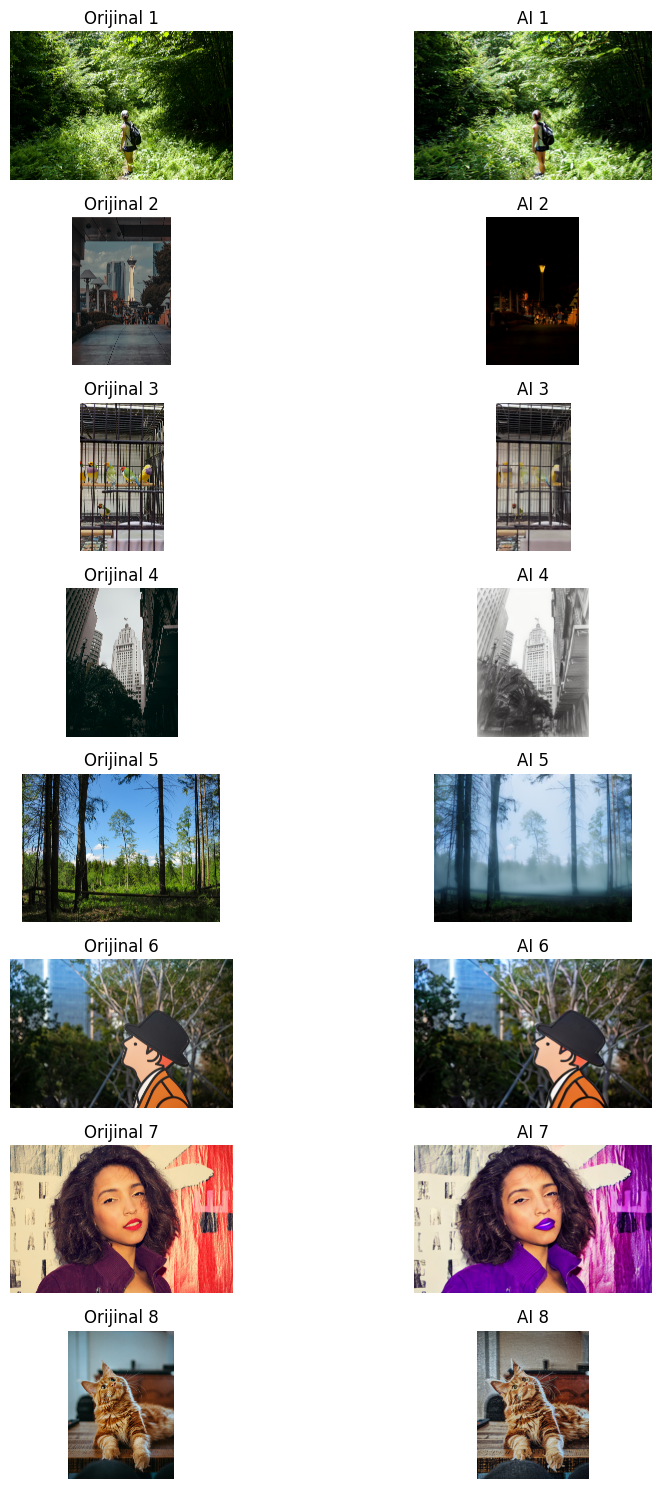

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import os

# "InstructPix2Pix" klasöründeki görselleri alalım
instructpix2pix_dir = os.path.join(output_base_dir, "InstructPix2Pix")
output_images = [f for f in os.listdir(instructpix2pix_dir) if f.endswith('.png')]
image_base_dir = os.path.join(base_project_dir, "Images")

# Eğer yeterli sayıda görsel varsa, rastgele 5 örnek seçelim
num_samples = 8
sampled_images = random.sample(output_images, num_samples)

# Görselleri görselleştirelim
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 15))

for i, img_file in enumerate(sampled_images):
    # Orijinal görselin yolu (output klasörü dışındaki orijinal resimler)
    original_img_path = os.path.join(image_base_dir, img_file.replace('_LowRes_output', ''))
    original_img = Image.open(original_img_path)

    # AI tarafından üretilen görselin yolu (InstructPix2Pix klasöründeki çıktı)
    ai_img_path = os.path.join(instructpix2pix_dir, img_file)
    ai_img = Image.open(ai_img_path)

    # Orijinal görseli ve AI tarafından üretilen görseli yan yana göster
    axes[i, 0].imshow(np.array(original_img))
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Orijinal {i+1}")

    axes[i, 1].imshow(np.array(ai_img))
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"AI {i+1}")

plt.tight_layout()
plt.show()
